# Livrable 2 - Image processing

## The subject
The goal is to process a set of photographs by denoising them in order to make them better processable by Machine Learning algorithms. In this Jupyter notebook we will explain the pre-processing steps. The algorithms will rely on convolutional auto-encoders, and apply them to improve the image quality.

## Import

### Disable Tensorflow's warnings

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

2022-10-20 15:49:41.865622: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Global Variables

In [3]:
RUN_DIR = 'data/'
BATCH_SIZE: int = 16
IMG_HEIGHT: int = 256
IMG_WIDTH: int = 256
EPOCHS: int = 200
ZIP_PATH: str = 'https://raw.githubusercontent.com/Stan-fld/auto_encoder_data/main/data_ae.zip'
DATASET_PATH: str = RUN_DIR + '2_denoise'

## Load dataset

### Import dataset from github

In [4]:
if not os.path.exists(DATASET_PATH):
    http_response = urlopen(ZIP_PATH)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=f'{RUN_DIR}2_denoise')

### Normal datasets

In [5]:
# Train
train_data = tf.keras.utils.image_dataset_from_directory(f'{RUN_DIR}/2_denoise/training/',
                                                         image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         batch_size=BATCH_SIZE)

# Train
val_data = tf.keras.utils.image_dataset_from_directory(f'{RUN_DIR}/2_denoise/validation/',
                                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       batch_size=BATCH_SIZE)

# Transforming BatchDataset into array 
train_data = np.concatenate(list(train_data.map(lambda x, y: x)))
val_data = np.concatenate(list(val_data.map(lambda x, y: x)))
train_data = train_data.astype('float32') / 255.
val_data = val_data.astype('float32') / 255.

Found 300 files belonging to 1 classes.
Found 60 files belonging to 1 classes.


### Noisy datasets

In [6]:
y_train = train_data

y_val = val_data

noise_factor = 0.2
x_train = train_data + noise_factor * np.random.normal(size=train_data.shape)
x_val = val_data + noise_factor * np.random.normal(size=val_data.shape)

x_train = np.clip(x_train, 0., 1.)
x_val = np.clip(x_val, 0., 1.)

## Implementation of functions to display the images.

In [7]:
def display_single_image(img):
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")


def display_image(x, n):
    plt.figure(figsize=(20, 5))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(np.array(x[i]), vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

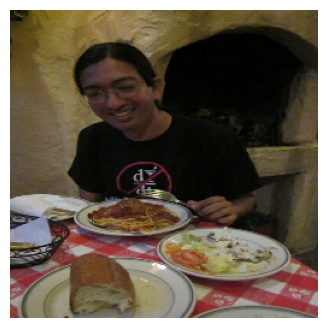

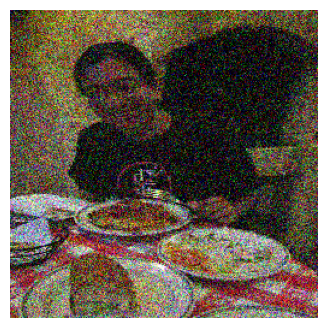

In [8]:
#Print an image of both datasets for testing
display_single_image(y_train[0])
display_single_image(x_train[0])

Training set


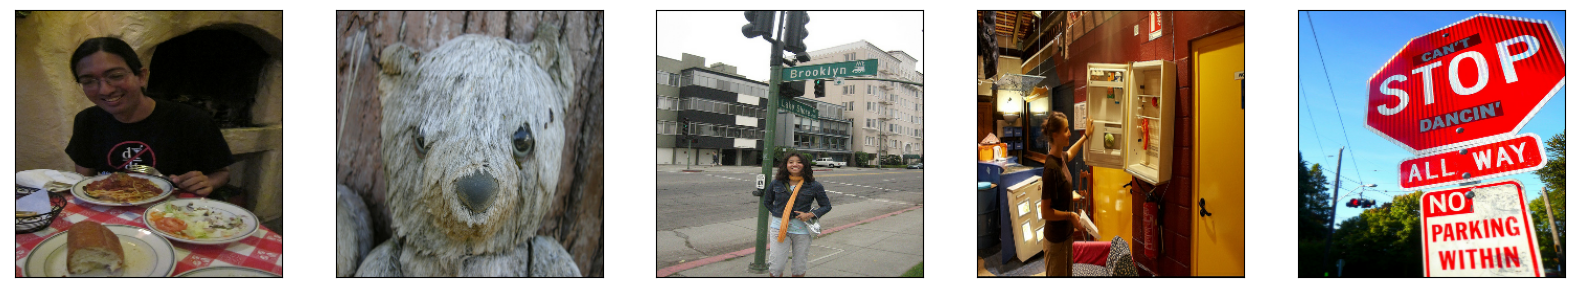

Noisy training set


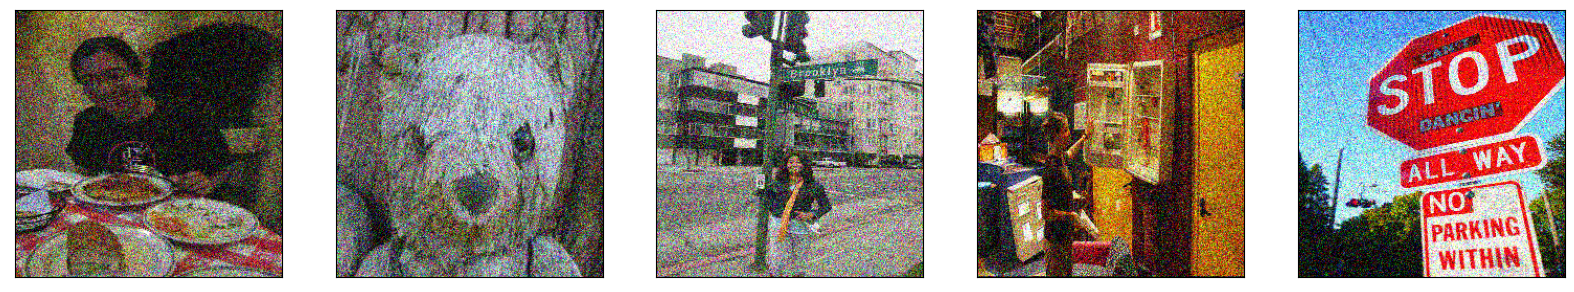

In [9]:
print("Training set")
display_image(y_train, 5)
print("Noisy training set")
display_image(x_train, 5)

## Encoder

In [10]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

encoder = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoder)
encoder = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
encoder = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoder)

## Decoder

In [11]:
decoder = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(encoder)
decoder = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(decoder)
decoder = tf.keras.layers.UpSampling2D((2, 2))(decoder)
decoder = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(decoder)
decoder = tf.keras.layers.UpSampling2D((2, 2))(decoder)

decoder = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), activation='sigmoid', padding='same')(decoder)

## Auto encoder

In [12]:
# Loss function
def ssim_accuracy(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()

auto_encoder = tf.keras.Model(inputs, decoder, name="auto_encoder")
auto_encoder.compile(optimizer=optimizer, loss=loss, metrics=[ssim_accuracy])

## Train the model

In [15]:
# auto_encoder.summary()

with tf.device('/GPU:0'):
    history = auto_encoder.fit(x_train, y_train,
                               batch_size=BATCH_SIZE,
                               epochs=EPOCHS,
                               verbose=1,
                               shuffle=True,
                               validation_data=(x_val, y_val),
                               callbacks=[callback_best_model]
                               )

Epoch 1/200
19/19 [==============================] - 8s 264ms/step - loss: 0.0473 - ssim_accuracy: 0.3725 - val_loss: 0.0231 - val_ssim_accuracy: 0.4543
Epoch 2/200
19/19 [==============================] - 3s 167ms/step - loss: 0.0206 - ssim_accuracy: 0.4304 - val_loss: 0.0155 - val_ssim_accuracy: 0.4923
Epoch 3/200
19/19 [==============================] - 3s 167ms/step - loss: 0.0136 - ssim_accuracy: 0.4782 - val_loss: 0.0127 - val_ssim_accuracy: 0.5344
Epoch 4/200
19/19 [==============================] - 3s 167ms/step - loss: 0.0121 - ssim_accuracy: 0.5083 - val_loss: 0.0101 - val_ssim_accuracy: 0.5544
Epoch 5/200
19/19 [==============================] - 3s 168ms/step - loss: 0.0103 - ssim_accuracy: 0.5263 - val_loss: 0.0091 - val_ssim_accuracy: 0.5728
Epoch 6/200
19/19 [==============================] - 3s 167ms/step - loss: 0.0094 - ssim_accuracy: 0.5402 - val_loss: 0.0082 - val_ssim_accuracy: 0.5873
Epoch 7/200
19/19 [==============================] - 3s 167ms/step - loss: 0.0091 

## Loss curve

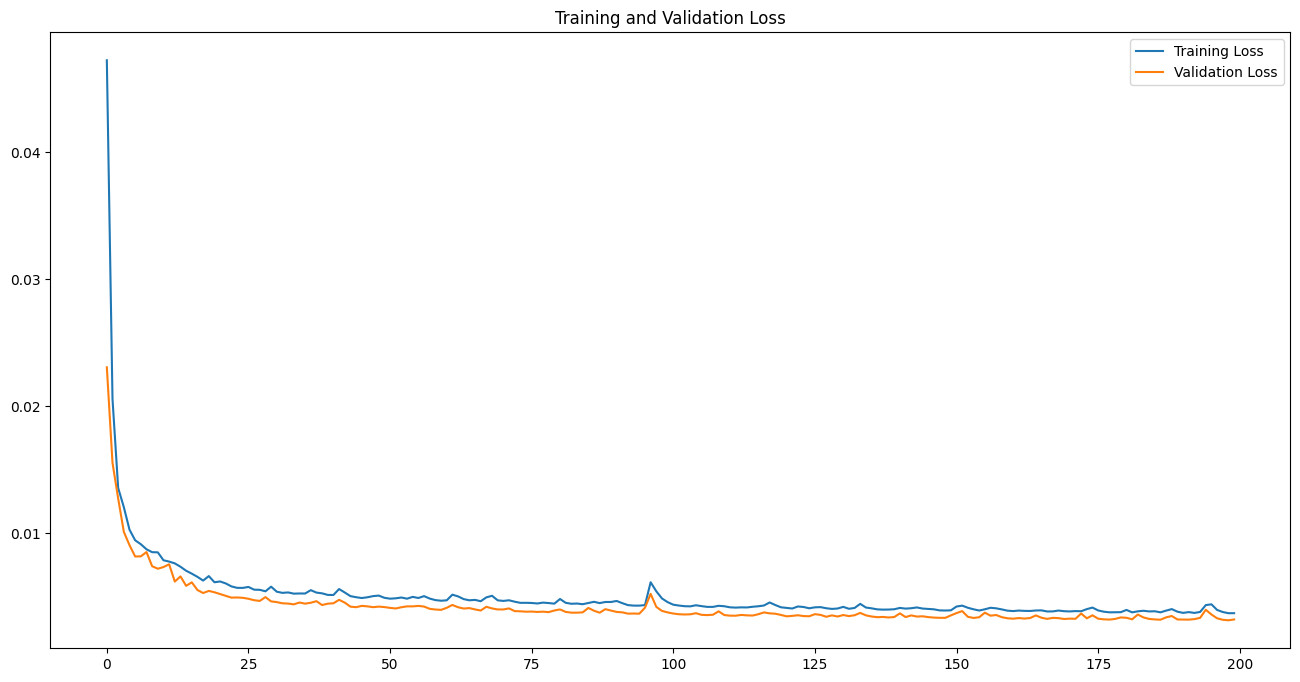

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(16, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Output

2/2 [==============================] - 3s 1s/step


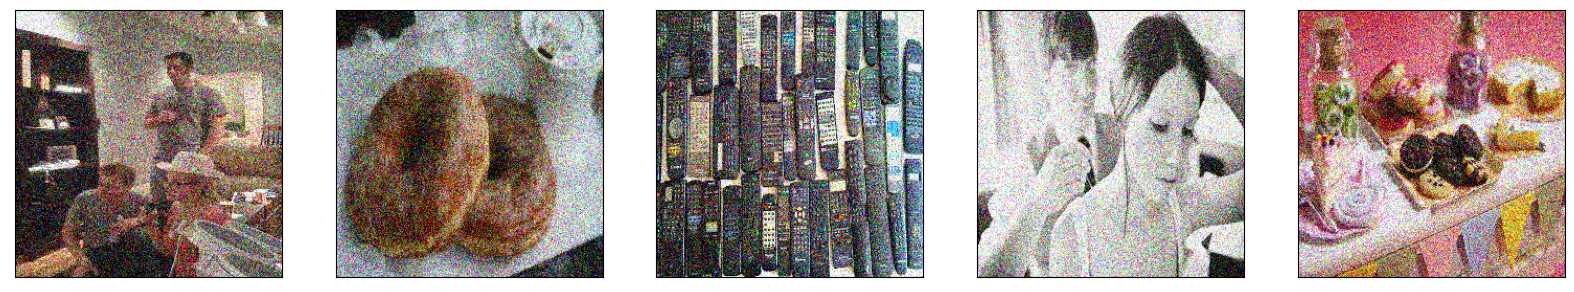

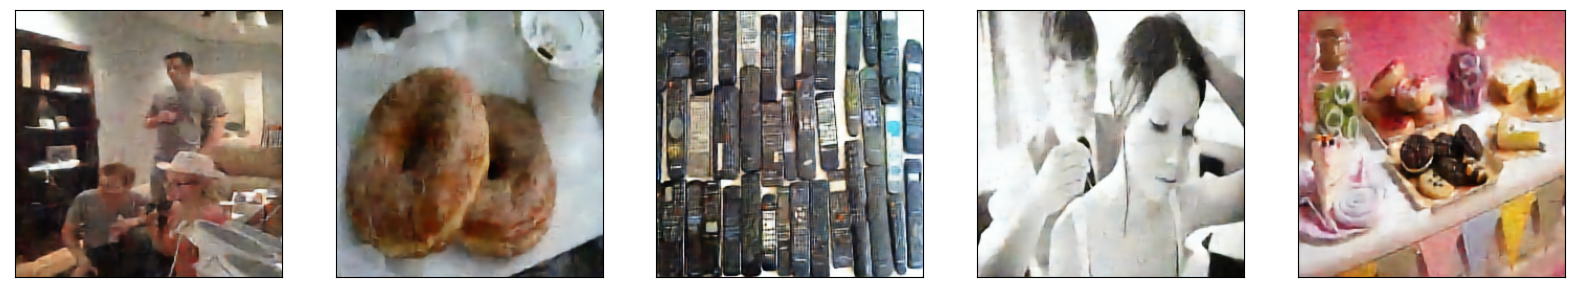

In [17]:
decoded_images = auto_encoder.predict(x_val)
display_image(x_val, n=5)
display_image(decoded_images, n=5)

## Save

In [19]:
date: datetime = datetime.datetime.now().strftime("%m.%d.%Y_%H:%M:%S")
model_dir: str = f"models/denoiser_{date}"
auto_encoder.save(model_dir)
f = open(f"{model_dir}/model_summary.txt", "a")
auto_encoder.summary(print_fn=lambda x: f.write(x + '\n'))
f.close()

f = open(f"{model_dir}/model_history.csv", "a")
f.write(pd.DataFrame.from_dict(history.history).to_csv(index=False))
f.close()

INFO:tensorflow:Assets written to: models/denoiser_10.20.2022_16:01:28/assets


INFO:tensorflow:Assets written to: models/denoiser_10.20.2022_16:01:28/assets
